In [1]:
import numpy as np
import pandas as pd

import os
import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18, resnet50, mobilenet_v3_small
import torch.nn as nn
import torch.nn.functional as F

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers, distances
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from pytorch_metric_learning.utils.inference import CustomKNN
import faiss

import open_clip

from sklearn.model_selection import train_test_split

from online_triplet_loss.losses import *


from tqdm.notebook import tqdm

from PIL import Image
import random



from matplotlib import pyplot as plt
import seaborn as sns

import warnings

import logging

warnings.filterwarnings("ignore")

### Prepare dataframe

In [2]:
df_train = pd.read_csv("Stanford_Online_Products/Ebay_train.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])

df_test = pd.read_csv("Stanford_Online_Products/Ebay_test.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])

In [3]:
df_train['class_id'] = df_train['class_id']-1
df_test['class_id'] = df_test['class_id']-1

In [4]:
num_classes = len(df_train['class_id'].value_counts())
num_classes

11318

In [5]:
groups = df_train.groupby(['super_class_id'])

In [6]:
for num, group in groups:
    print(f"group {num}:")
    sub_group=sorted(group['class_id'].value_counts().index.values)
    val_len=int(0.75*len(sub_group))
    train_indexes = sub_group[:val_len]
    val_indexes = sub_group[val_len:]
    print(train_indexes)
    print(val_indexes)
    print(sub_group)

group (1,):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [7]:
def train_valid_split(dataset, valid_size):

    train_classes = []
    valid_classes = []

    groups = dataset.groupby(['super_class_id'])

    train_size = 1-valid_size

    for num, group in groups:

        sub_indexes=sorted(group['class_id'].value_counts().index.values)
        train_len=int(train_size*len(sub_indexes))
        train_classes.extend(sub_indexes[:train_len])
        valid_classes.extend(sub_indexes[train_len:])



    train_set = dataset[dataset['class_id'].isin(train_classes)]
    valid_set = dataset[dataset['class_id'].isin(valid_classes)]

    return train_set, valid_set

In [8]:
df_train, df_valid = train_valid_split(df_train, 0.1)

In [9]:
df_train.shape

(53513, 4)

In [10]:
df_valid.shape

(6038, 4)

In [11]:
df_valid.shape[0]/df_train.shape[0]

0.11283239586642498

### Check that we have all superclasses in train and valid sets

In [12]:
df_train['super_class_id'].value_counts().sort_index()

super_class_id
1     3768
2     5214
3     5249
4     4480
5     2703
6     4508
7     5701
8     5996
9     3110
10    3912
11    4981
12    3891
Name: count, dtype: int64

In [13]:
df_valid['super_class_id'].value_counts().sort_index()

super_class_id
1     400
2     634
3     596
4     505
5     290
6     505
7     603
8     735
9     362
10    455
11    489
12    464
Name: count, dtype: int64

In [14]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [15]:
print(f"Length of train {len(df_train)}")
print(f"Length of validation {len(df_valid)}")
print(f"Length of test {len(df_test)}")

Length of train 53513
Length of validation 6038
Length of test 60502


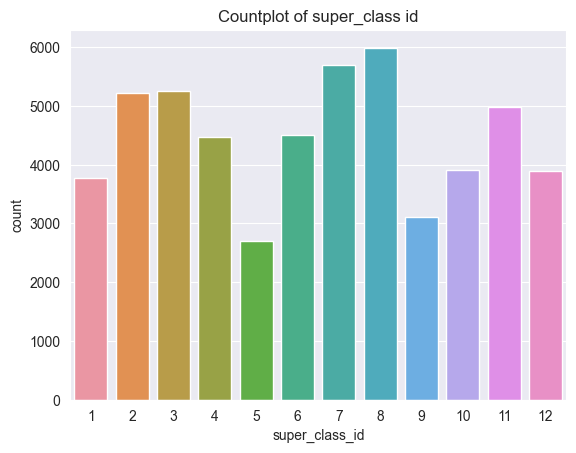

In [16]:
plt.title("Countplot of super_class id")
sns.countplot(data=df_train, x='super_class_id')
plt.show()

In [17]:
PATH = "Stanford_Online_Products"

In [18]:
class ProductDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.data_csv = df
        self.transform = transform
        self.path = path
        self.images = df["path"].values
        self.labels = df["class_id"].values
        self.index = df.index.values



    def __len__(self):
        return len(self.images)


    def __getitem__(self, item):
        image_name = self.images[item]
        image_path = self.path + "/" + image_name
        ###### Anchor Image #######
        img = Image.open(image_path).convert("RGB")
        label = self.labels[item]



        # if self.preprocess != None:
        #     img = self.preprocess(img)


        if self.transform != None:
            img = self.transform(img)

        return img, label





train_transform =transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [19]:
trainDS = ProductDataset(df=df_train, path=PATH, transform=train_transform)

testDS = ProductDataset(df=df_test, path=PATH, transform=val_transform)

validDS = ProductDataset(df=df_valid, path=PATH, transform=val_transform)

In [20]:
BATCH_SIZE = 128

In [21]:
#use hierarchical sampler with super_class_id and class_id

train_sampler = samplers.HierarchicalSampler(
        labels = df_train[['super_class_id', 'class_id']].values,
        batch_size = BATCH_SIZE,
        samples_per_class = 4,
        batches_per_super_tuple=4,
        super_classes_per_batch=2,
        inner_label=1,
        outer_label=0,
    )

valid_sampler = samplers.HierarchicalSampler(
        labels = df_valid[['super_class_id', 'class_id']].values,
        batch_size = BATCH_SIZE,
        samples_per_class = 4,
        batches_per_super_tuple=4,
        super_classes_per_batch=2,
        inner_label=1,
        outer_label=0,
    )

In [22]:
trainLoader = DataLoader(trainDS, batch_sampler = train_sampler)

validLoader = DataLoader(validDS, batch_sampler = valid_sampler)

testLoader = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
images, labels = next(iter(trainLoader))

In [30]:
images[0].shape

torch.Size([3, 224, 224])

In [31]:
images[0]

tensor([[[1.7352, 1.0673, 0.4851,  ..., 2.2489, 2.2489, 2.2489],
         [1.8550, 1.2043, 0.5878,  ..., 2.2489, 2.2489, 2.2489],
         [2.0092, 1.4269, 0.7248,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.1804, 2.1462, 2.0948,  ..., 2.2489, 2.2489, 2.2489],
         [2.1804, 2.1804, 2.1633,  ..., 2.2489, 2.2489, 2.2489],
         [2.1804, 2.1975, 2.2147,  ..., 2.2489, 2.2489, 2.2489]],

        [[1.8683, 1.1155, 0.4153,  ..., 2.4286, 2.4286, 2.4286],
         [1.9909, 1.2731, 0.5203,  ..., 2.4286, 2.4286, 2.4286],
         [2.1660, 1.5007, 0.6779,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.3936, 2.3585, 2.3060,  ..., 2.4286, 2.4286, 2.4286],
         [2.3936, 2.3761, 2.3585,  ..., 2.4286, 2.4286, 2.4286],
         [2.3936, 2.3936, 2.3936,  ..., 2.4286, 2.4286, 2.4286]],

        [[1.6465, 0.8274, 0.0431,  ..., 2.6400, 2.6400, 2.6400],
         [1.7860, 0.9842, 0.1476,  ..., 2.6400, 2.6400, 2.6400],
         [1.9951, 1.2282, 0.3219,  ..., 2.6400, 2.6400, 2.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


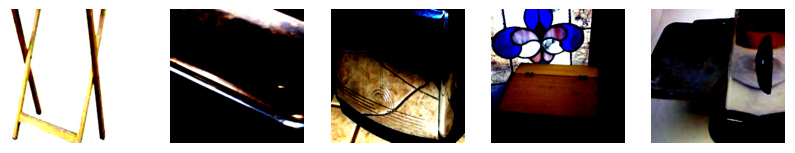

In [32]:
plt.figure(figsize=(10, 50))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis("off")
plt.show()

In [24]:
import timm
mobilenetv3 = timm.create_model('mobilenetv3_small_100', pretrained=True)

In [25]:
mobilenetv3

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): ReLU(inplace=True)
          (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Hardsigmoid()
        )
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          

In [26]:
EMBED_DIMS = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.0001
EPOCHS = 20

In [27]:
class Mobile_ArcFace(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = mobilenetv3
        num_filters = self.Feature_Extractor.classifier.in_features
        self.Feature_Extractor.classifier = nn.Sequential(
                  nn.Linear(num_filters, EMBED_DIMS))

    def forward(self,x):
        x = self.Feature_Extractor(x)
        x = F.normalize(x, p=2, dim=1)

        return x

In [28]:
model = Mobile_ArcFace()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [29]:
num_classes

11318

In [30]:
# Set the loss function
# criterion = losses.TripletMarginLoss(margin=0.1)
#distance = distances.LpDistance(p=2, normalize_embeddings=False, power=1)

# loss_func = losses.MarginLoss(margin=0.2,
#                 nu=0,
#                 beta=1.2,
#                 triplets_per_anchor="all",
#                 learn_beta=True,
#                 num_classes=None)

loss_func = losses.ArcFaceLoss(num_classes, EMBED_DIMS, margin=28.6, scale=64)

loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=0.01)

#loss_func = losses.TripletMarginLoss(margin=0.2)

#loss_optimizer = torch.optim.SGD(loss_func.parameters(), lr=0.0001, momentum=0.9)

#mining_func = miners.TripletMarginMiner(margin=0.2, type_of_triplets="semihard")



# accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

In [31]:
def top_k_accuracy(predictions, labels):
    '''
    compute number of valid results among first k-1 nearest neighbours
    first neighbour is always itself, that's why it is not taken into consideration
    '''

    accur = 0
    for i, label in enumerate(labels):
        #if correct item is among 4 neighbors than we have a success
        #not include itself -> ([1:])
        accur += np.sum(predictions[i][1:]==label.item())>0
    return accur/len(predictions)

In [32]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        #distance is calculated by inner product
        self.index = faiss.IndexFlatIP(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        #use 5 neighbors
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        labels = self.y[indices]
        #predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return indices, labels


In [58]:
valid_embeddings, valid_labels = get_all_embeddings(validDS, model)

  0%|          | 0/6038 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [465]:
valid_labels.dtype

torch.int64

In [469]:
loss_func(valid_embeddings.squeeze(1), valid_labels.squeeze(1))

tensor(44.5453, grad_fn=<MeanBackward0>)

In [457]:
valid_labels

tensor([[  487.],
        [  487.],
        [  487.],
        ...,
        [11317.],
        [11317.],
        [11317.]])

In [34]:
def train(model, loss_func, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        #indices_tuple = mining_func(embeddings, labels)
        #loss = loss_func(embeddings, labels, indices_tuple)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {:.4f}".format(epoch, batch_idx, loss)
            )
        losses.append(loss.detach().numpy())
    return np.mean(losses)



def get_all_embeddings(dataset, model):

    #make dataloader of 1 element in the batch
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    all_embeddings = torch.zeros(len(dataloader), EMBED_DIMS, dtype=torch.float32)
    all_labels = torch.zeros(len(dataloader), 1, dtype=torch.long)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader)):
            images, labels = data[0], data[1]
            embeddings = model(images)
            all_embeddings[i]=embeddings
            all_labels[i]=labels

    return all_embeddings, all_labels




def eval(valid_set, model, accuracy_calculator):

    model.eval()

    print("compute embeddings of valid set")
    valid_embeddings, valid_labels = get_all_embeddings(valid_set, model)

    valid_labels = valid_labels.squeeze(1)

    valid_loss = loss_func(valid_embeddings, valid_labels)


    print("Computing accuracy")
    faiss_knn = FaissKNeighbors()
    faiss_knn.fit(valid_embeddings.numpy(), valid_labels.numpy())
    indices, predicted_labels = faiss_knn.predict(valid_embeddings.numpy())
    top_4_accuracy = accuracy_calculator(predicted_labels, valid_labels)
    # accuracies = accuracy_calculator.get_accuracy(
    #     valid_embeddings, valid_labels, valid_embeddings, valid_labels, False)
    print("Validation set accuracy (Accuracy@4) = {}".format(top_4_accuracy))

    return valid_loss


In [35]:
train_losses = []
valid_losses =[]
min_loss = 100
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, loss_func, trainLoader, optimizer, epoch)
    print(f"Epoch{epoch}/{EPOCHS}: Mean train Loss {train_loss: .4f}")
    train_losses.append(train_loss)
    if train_loss < min_loss:
        torch.save(model, "models/model.pts")
        print("Model saved!")
        min_loss = train_loss
    valid_loss = eval(validDS, model, top_k_accuracy)
    valid_losses.append(valid_loss)
    print(f"Valid loss: {valid_loss: .4f}")

Epoch 1 Iteration 0: Loss = 53.1606
Epoch 1 Iteration 20: Loss = 50.8342
Epoch 1 Iteration 40: Loss = 46.7163
Epoch 1 Iteration 60: Loss = 43.3383
Epoch 1 Iteration 80: Loss = 42.4268
Epoch 1 Iteration 100: Loss = 43.2636
Epoch 1 Iteration 120: Loss = 41.1861
Epoch 1 Iteration 140: Loss = 41.5281
Epoch 1 Iteration 160: Loss = 40.3343
Epoch 1 Iteration 180: Loss = 40.1171
Epoch 1 Iteration 200: Loss = 40.6132
Epoch 1 Iteration 220: Loss = 40.7191
Epoch 1 Iteration 240: Loss = 40.0043
Epoch 1 Iteration 260: Loss = 40.5643
Epoch1/20: Mean train Loss  43.1231
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.5654190129181849
Valid loss:  42.8640
Epoch 2 Iteration 0: Loss = 40.1116
Epoch 2 Iteration 20: Loss = 39.7824
Epoch 2 Iteration 40: Loss = 39.6218
Epoch 2 Iteration 60: Loss = 39.0331
Epoch 2 Iteration 80: Loss = 38.9255
Epoch 2 Iteration 100: Loss = 39.3619
Epoch 2 Iteration 120: Loss = 39.1847
Epoch 2 Iteration 140: Loss = 38.9444
Epoch 2 Iteration 160: Loss = 40.1668
Epoch 2 Iteration 180: Loss = 38.6757
Epoch 2 Iteration 200: Loss = 37.3855
Epoch 2 Iteration 220: Loss = 38.1694
Epoch 2 Iteration 240: Loss = 39.7655
Epoch 2 Iteration 260: Loss = 38.0934
Epoch2/20: Mean train Loss  39.1253
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.605498509440212
Valid loss:  41.9789
Epoch 3 Iteration 0: Loss = 38.1019
Epoch 3 Iteration 20: Loss = 37.7181
Epoch 3 Iteration 40: Loss = 37.8179
Epoch 3 Iteration 60: Loss = 37.5569
Epoch 3 Iteration 80: Loss = 37.4999
Epoch 3 Iteration 100: Loss = 37.4362
Epoch 3 Iteration 120: Loss = 36.8505
Epoch 3 Iteration 140: Loss = 37.6558
Epoch 3 Iteration 160: Loss = 37.7944
Epoch 3 Iteration 180: Loss = 36.3399
Epoch 3 Iteration 200: Loss = 37.1317
Epoch 3 Iteration 220: Loss = 37.4520
Epoch 3 Iteration 240: Loss = 37.1913
Epoch 3 Iteration 260: Loss = 36.9667
Epoch3/20: Mean train Loss  37.4321
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.6462404769791321
Valid loss:  40.8260
Epoch 4 Iteration 0: Loss = 36.4765
Epoch 4 Iteration 20: Loss = 36.4915
Epoch 4 Iteration 40: Loss = 36.1030
Epoch 4 Iteration 60: Loss = 35.9603
Epoch 4 Iteration 80: Loss = 36.0485
Epoch 4 Iteration 100: Loss = 35.9081
Epoch 4 Iteration 120: Loss = 36.1112
Epoch 4 Iteration 140: Loss = 36.4657
Epoch 4 Iteration 160: Loss = 36.1560
Epoch 4 Iteration 180: Loss = 35.6728
Epoch 4 Iteration 200: Loss = 35.9679
Epoch 4 Iteration 220: Loss = 35.1236
Epoch 4 Iteration 240: Loss = 35.5152
Epoch 4 Iteration 260: Loss = 34.9278
Epoch4/20: Mean train Loss  35.9576
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.6702550513415038
Valid loss:  39.4211
Epoch 5 Iteration 0: Loss = 34.8070
Epoch 5 Iteration 20: Loss = 34.7713
Epoch 5 Iteration 40: Loss = 34.6866
Epoch 5 Iteration 60: Loss = 35.1727
Epoch 5 Iteration 80: Loss = 34.8488
Epoch 5 Iteration 100: Loss = 34.5356
Epoch 5 Iteration 120: Loss = 34.3538
Epoch 5 Iteration 140: Loss = 34.5155
Epoch 5 Iteration 160: Loss = 34.0084
Epoch 5 Iteration 180: Loss = 34.0428
Epoch 5 Iteration 200: Loss = 33.7837
Epoch 5 Iteration 220: Loss = 34.3157
Epoch 5 Iteration 240: Loss = 33.8923
Epoch 5 Iteration 260: Loss = 33.0550
Epoch5/20: Mean train Loss  34.4404
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.686816826763829
Valid loss:  37.8114
Epoch 6 Iteration 0: Loss = 33.8172
Epoch 6 Iteration 20: Loss = 33.4925
Epoch 6 Iteration 40: Loss = 33.6639
Epoch 6 Iteration 60: Loss = 33.4934
Epoch 6 Iteration 80: Loss = 32.8847
Epoch 6 Iteration 100: Loss = 33.1894
Epoch 6 Iteration 120: Loss = 32.5192
Epoch 6 Iteration 140: Loss = 32.7299
Epoch 6 Iteration 160: Loss = 32.8545
Epoch 6 Iteration 180: Loss = 32.9196
Epoch 6 Iteration 200: Loss = 32.8144
Epoch 6 Iteration 220: Loss = 32.5903
Epoch 6 Iteration 240: Loss = 32.1499
Epoch 6 Iteration 260: Loss = 32.3843
Epoch6/20: Mean train Loss  32.8792
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.6926134481616429
Valid loss:  36.0130
Epoch 7 Iteration 0: Loss = 31.8260
Epoch 7 Iteration 20: Loss = 32.0977
Epoch 7 Iteration 40: Loss = 32.0913
Epoch 7 Iteration 60: Loss = 31.5223
Epoch 7 Iteration 80: Loss = 31.5335
Epoch 7 Iteration 100: Loss = 31.2121
Epoch 7 Iteration 120: Loss = 31.5591
Epoch 7 Iteration 140: Loss = 30.8972
Epoch 7 Iteration 160: Loss = 31.1102
Epoch 7 Iteration 180: Loss = 31.0285
Epoch 7 Iteration 200: Loss = 30.6108
Epoch 7 Iteration 220: Loss = 30.7985
Epoch 7 Iteration 240: Loss = 30.7322
Epoch 7 Iteration 260: Loss = 30.6288
Epoch7/20: Mean train Loss  31.2553
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.7035442199403776
Valid loss:  34.0356
Epoch 8 Iteration 0: Loss = 30.5256
Epoch 8 Iteration 20: Loss = 30.3116
Epoch 8 Iteration 40: Loss = 29.8635
Epoch 8 Iteration 60: Loss = 29.8652
Epoch 8 Iteration 80: Loss = 29.9722
Epoch 8 Iteration 100: Loss = 29.7771
Epoch 8 Iteration 120: Loss = 29.6679
Epoch 8 Iteration 140: Loss = 29.4467
Epoch 8 Iteration 160: Loss = 29.2518
Epoch 8 Iteration 180: Loss = 29.1039
Epoch 8 Iteration 200: Loss = 29.0293
Epoch 8 Iteration 220: Loss = 28.9612
Epoch 8 Iteration 240: Loss = 28.8671
Epoch 8 Iteration 260: Loss = 28.5290
Epoch8/20: Mean train Loss  29.5223
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.7141437562106658
Valid loss:  31.8122
Epoch 9 Iteration 0: Loss = 28.3013
Epoch 9 Iteration 20: Loss = 28.5769
Epoch 9 Iteration 40: Loss = 28.1575
Epoch 9 Iteration 60: Loss = 27.9590
Epoch 9 Iteration 80: Loss = 28.0676
Epoch 9 Iteration 100: Loss = 27.8996
Epoch 9 Iteration 120: Loss = 27.7455
Epoch 9 Iteration 140: Loss = 27.4870
Epoch 9 Iteration 160: Loss = 27.5096
Epoch 9 Iteration 180: Loss = 27.1921
Epoch 9 Iteration 200: Loss = 27.0791
Epoch 9 Iteration 220: Loss = 27.0313
Epoch 9 Iteration 240: Loss = 26.7149
Epoch 9 Iteration 260: Loss = 26.6681
Epoch9/20: Mean train Loss  27.6203
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.7114938721430938
Valid loss:  29.2220
Epoch 10 Iteration 0: Loss = 26.5659
Epoch 10 Iteration 20: Loss = 26.4836
Epoch 10 Iteration 40: Loss = 26.2633
Epoch 10 Iteration 60: Loss = 26.0266
Epoch 10 Iteration 80: Loss = 26.0365
Epoch 10 Iteration 100: Loss = 25.8439
Epoch 10 Iteration 120: Loss = 25.6616
Epoch 10 Iteration 140: Loss = 25.6157
Epoch 10 Iteration 160: Loss = 25.2439
Epoch 10 Iteration 180: Loss = 25.0522
Epoch 10 Iteration 200: Loss = 24.8994
Epoch 10 Iteration 220: Loss = 24.7493
Epoch 10 Iteration 240: Loss = 24.5989
Epoch 10 Iteration 260: Loss = 24.2186
Epoch10/20: Mean train Loss  25.4926
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.7174561112951309
Valid loss:  27.5711
Epoch 11 Iteration 0: Loss = 24.2705
Epoch 11 Iteration 20: Loss = 24.2384
Epoch 11 Iteration 40: Loss = 24.0316
Epoch 11 Iteration 60: Loss = 23.8293
Epoch 11 Iteration 80: Loss = 23.5385
Epoch 11 Iteration 100: Loss = 23.2844
Epoch 11 Iteration 120: Loss = 23.2373
Epoch 11 Iteration 140: Loss = 22.9195
Epoch 11 Iteration 160: Loss = 22.8050
Epoch 11 Iteration 180: Loss = 22.5428
Epoch 11 Iteration 200: Loss = 22.3033
Epoch 11 Iteration 220: Loss = 22.1865
Epoch 11 Iteration 240: Loss = 21.9782
Epoch 11 Iteration 260: Loss = 21.7491
Epoch11/20: Mean train Loss  23.0580
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.7017224246439219
Valid loss:  29.5872
Epoch 12 Iteration 0: Loss = 21.6031
Epoch 12 Iteration 20: Loss = 21.4801
Epoch 12 Iteration 40: Loss = 21.3127
Epoch 12 Iteration 60: Loss = 21.0150
Epoch 12 Iteration 80: Loss = 20.8381
Epoch 12 Iteration 100: Loss = 20.6249
Epoch 12 Iteration 120: Loss = 20.3329
Epoch 12 Iteration 140: Loss = 20.0752
Epoch 12 Iteration 160: Loss = 19.8582
Epoch 12 Iteration 180: Loss = 19.6044
Epoch 12 Iteration 200: Loss = 19.3026
Epoch 12 Iteration 220: Loss = 19.1021
Epoch 12 Iteration 240: Loss = 18.7998
Epoch 12 Iteration 260: Loss = 18.5559
Epoch12/20: Mean train Loss  20.1525
Model saved!
compute embeddings of valid set


  0%|          | 0/6038 [00:00<?, ?it/s]

Computing accuracy
Validation set accuracy (Accuracy@4) = 0.6561775422325273
Valid loss:  30.6393
Epoch 13 Iteration 0: Loss = 18.4853
Epoch 13 Iteration 20: Loss = 18.2481
Epoch 13 Iteration 40: Loss = 17.9693
Epoch 13 Iteration 60: Loss = 17.6756
Epoch 13 Iteration 80: Loss = 17.4205
Epoch 13 Iteration 100: Loss = 18.5407
Epoch 13 Iteration 120: Loss = 22.1110
Epoch 13 Iteration 140: Loss = 22.1759
Epoch 13 Iteration 160: Loss = 24.1348


KeyboardInterrupt: 

In [ ]:
valid_losses = list(map(lambda x: x.item(), valid_losses))

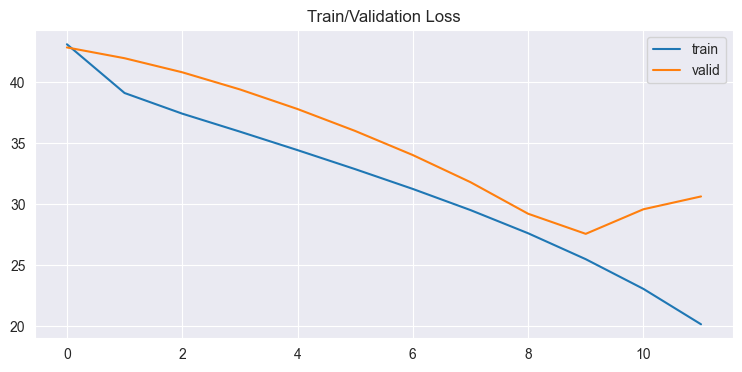

In [46]:
plt.figure(figsize=(9,4))
plt.plot(range(len(train_losses)), train_losses, label="train")
plt.plot(range(len(valid_losses)), valid_losses, label="valid")
plt.legend(loc="upper right")
plt.title("Train/Validation Loss")
plt.show()

In [47]:
model = torch.load("models/model.pts")

### Compute nearest neighbors from test set